In [22]:
import pandas as pd
from scipy import special, integrate
import numpy as np
from yahoo_fin import options
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from datetime import datetime

In [2]:
plt.style.use('fivethirtyeight')

In [61]:
def CharFunc(u, params, type, dt, r):

    if type == 1: # Gaussian distribution
        mu, sigma = params[0], params[1]
        return np.exp(dt*(1j * u * mu - 0.5 * (sigma**2) * (u**2)))
    elif type == 2: # Variance Gamma distribution
        mu, theta, sigma, kappa = params[0], params[1], params[2], params[3]
        return np.exp(1j * u * mu * dt) * (1 - 1j * u * theta * kappa + 0.5 * (u**2) * (sigma**2) * kappa) ** (-dt / kappa)
    elif type == 3: # Normal inverse Gaussian distribution
        mu, theta, sigma, kappa = params[0], params[1], params[2], params[3]
        return np.exp(1j * u * mu * dt + dt/kappa * (1 - np.sqrt(1 + (u**2) * (sigma**2) * kappa - 2 * 1j * u * theta * kappa)))
    elif type == 4: # CGMY distribution
        mu, C, G, M, Y = params[0], params[1], params[2], params[3], params[4]
        return np.exp(1j * u * mu * dt + C * special.gamma(-Y) * dt * ((M - 1j * u) ** Y - (M**Y) + (G + 1j * u) ** Y - (G**Y)))
    elif type == 5: # Merton Jump Diffusion
        mu, sigma, l, mu_z, sigma_z = params[0], params[1], params[2], params[3], params[4]
        phi_Y = np.exp(1j * u * mu_z - 0.5 * (sigma_z**2) * (u**2))
        return np.exp(dt * (1j * u * mu - 0.5 * (sigma**2) * (u**2)) + l * (phi_Y - 1))
    elif type == 6: # Kou Jump Diffusion
        mu, sigma, l, p, eta1, eta2 = params[0], params[1], params[2], params[3], params[4], params[5]
        q = 1 - p
        phi_Y = p * eta1/(eta1 * 1j * u) + q * eta2/(eta2 * 1j * u)
        return np.exp(dt * (1j * u * mu - 0.5 * (sigma**2) * (u**2)) + l * (phi_Y - 1))
    elif type == 7: # Heston
        mu, sigma, k, neta, theta, rho = params[0], params[1], params[2], params[3], params[4], params[5]
        d = ((rho * theta * u * 1j - k)**2 - (theta**2) * (-1j * u - (u**2))) ** 0.5
        rep = k - rho * theta * u * 1j - d
        g = rep/(rep + 2 * d)
        tmp1 = np.exp(1j * u * mu * dt)
        tmp2 = np.exp(neta * k * (theta**-2) * (rep * dt - 2 * np.log((1 - g * np.exp(-d * dt))/(1 - g))))
        tmp3 = np.exp(sigma * (theta**-2) * rep * (1 - np.exp(-d * dt))/(1 - g * np.exp(-d * dt)))
        return tmp1 * tmp2 * tmp3

In [45]:
def call_option_transform(u, K, R):
    return (K ** (1 - R - 1j * u))/((1 - R - 1j * u) * (- R - 1j * u))

In [16]:
tick = 'AAPL'
exp_date = options.get_expiration_dates(tick)[0]
calls = pd.DataFrame()
calls = options.get_calls(tick)
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Contract Name       47 non-null     object 
 1   Last Trade Date     47 non-null     object 
 2   Strike              47 non-null     float64
 3   Last Price          47 non-null     float64
 4   Bid                 47 non-null     float64
 5   Ask                 47 non-null     float64
 6   Change              47 non-null     float64
 7   % Change            47 non-null     object 
 8   Volume              47 non-null     object 
 9   Open Interest       47 non-null     int64  
 10  Implied Volatility  47 non-null     object 
dtypes: float64(5), int64(1), object(5)
memory usage: 4.2+ KB


In [17]:
calls['Implied Volatility'] = calls['Implied Volatility'].str.replace('%', '').astype(float)/100
calls = calls.drop(['Contract Name', 'Last Trade Date', 'Last Price', 'Ask', 'Change', '% Change', 'Volume', 'Open Interest'], axis=1)
calls

,Strike,Bid,Implied Volatility
0,95.0,87.10,2.1016
1,100.0,82.10,2.0547
2,110.0,72.10,1.7500
3,115.0,67.10,1.6094
4,120.0,62.10,1.4766
5,125.0,57.15,1.4023
6,130.0,52.15,1.3125
7,135.0,47.15,1.1836
8,140.0,42.15,1.0547
9,145.0,37.15,0.9316


In [18]:
def BlackScholesCall(S,K,r,T,sigma):
    d1 = ( (np.log(S/K)+(r+0.5*sigma**2)*T) / (sigma*np.sqrt(T)) )
    d2 = ( (np.log(S/K)+(r-0.5*sigma**2)*T) / (sigma*np.sqrt(T)) )
    BSCall = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return BSCall

In [24]:
stock = yf.Ticker(tick)
price = stock.history(period='1d')
S = price['Close'][0]
r = 0.05
T = (datetime.strptime(exp_date, '%B %d, %Y') - datetime.today()).days/366
for i in range(calls.shape[0]):
    calls.loc[i, 'Calculated Price'] = BlackScholesCall(S, calls.loc[i, 'Strike'], r, T, calls.loc[i, 'Implied Volatility'])

calls['Price delta'] = calls['Bid'] - calls['Calculated Price']
calls

,Strike,Bid,Implied Volatility,Calculated Price,Price delta
0,95.0,87.10,2.1016,87.350861,-0.250861
1,100.0,82.10,2.0547,82.355110,-0.255110
2,110.0,72.10,1.7500,72.359349,-0.259349
3,115.0,67.10,1.6094,67.361553,-0.261553
4,120.0,62.10,1.4766,62.363871,-0.263871
5,125.0,57.15,1.4023,57.369176,-0.219176
6,130.0,52.15,1.3125,52.375029,-0.225029
7,135.0,47.15,1.1836,47.377774,-0.227774
8,140.0,42.15,1.0547,42.380195,-0.230195
9,145.0,37.15,0.9316,37.383028,-0.233028


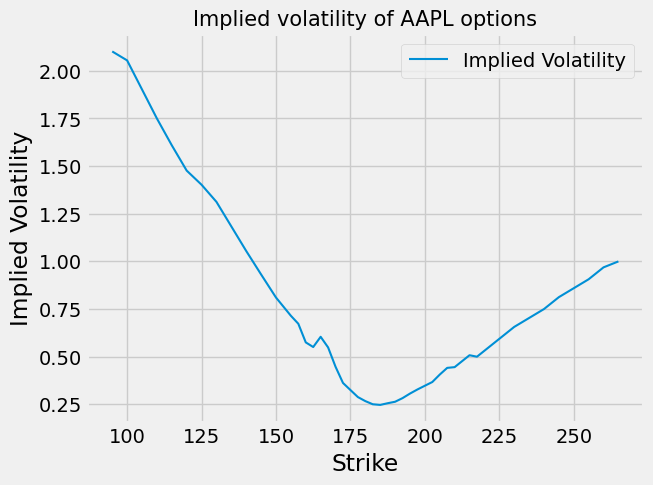

In [20]:
calls.plot('Strike', 'Implied Volatility', linewidth=1.5)
plt.title(f'Implied volatility of {tick} options', fontsize=15)
plt.ylabel('Implied Volatility')
plt.show()

In [59]:
def fourier_pricing(type, params, K, S, r, T):
    R = 1.1
    s = -np.log(S)
    q = 0
    if type == 7:
        omega = 0
    else:
        omega = np.log(CharFunc(-1j, params, type, T, r))

    mu = r - q - omega
    params[0] = mu

    c_mod = pd.Series()
    for i in range(calls.shape[0]):
        c_mod.loc[i] = K.loc[i] * np.exp(-r * T) * np.exp(-R * s)/np.pi * integrate.quad(lambda u: (np.exp(-1j * u * s) * 
                                                                                        CharFunc(u - 1j * R, params, type, T, r) * 
                                                                                        call_option_transform(u, K.loc[i], R)).real, 
                                                                                        0, np.inf)
    
    return c_mod

In [ ]:
type = 3
theta = -0.3
sigma = 0.20
kappa = 0.03
init_guess = [theta, sigma, kappa]
mu = 0
params = [mu, theta, sigma, kappa]

K = calls['Strike']
res = minimize(sum((calls['Bid'] - fourier_pricing(type, params, K, S, r, T))**2), init_guess, method='Nelder-Mead')